<a href="https://colab.research.google.com/github/dweebee/pytorch-practices/blob/main/01_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root="./data", train=True, download=True)
fm_test = FashionMNIST(root="./data", train=False, download=True)

train_input = fm_train.data
train_target = fm_train.targets
train_scaled = train_input / 255.0

from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.31MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 135kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.56MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.9MB/s]


In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 10)
)

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

In [ ]:
epochs = 20
batches = int(len(train_scaled)/32)
for epoch in range(epochs):
    # [1]학습
    model.train()
    train_loss = 0
    for i in range(batches):
        inputs = train_scaled[i*32:(i+1)*32].to(device)
        targets = train_target[i*32:(i+1)*32].to(device)
        optimizer.zero_grad()

        # 순전파 - 손실계산 - 역전파 - 가중치 업뎃
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # [2]평가
    model.eval() # dropout, batchnorm 비활성화
    val_loss = 0
    with torch.no_grad(): # 그래디언트 계산 비활성화 → 메모리 절약
        val_scaled = val_scaled.to(device)
        val_target = val_target.to(device)
        val_outputs = model(val_scaled)
        val_loss = criterion(val_outputs, val_target)
        val_loss = val_loss.item()

    train_hist.append(train_loss/batches)
    val_hist.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/batches:.4f}, Val Loss: {val_loss:.4f}")

    # [3]조기종료
    if best_loss == -1 or val_loss < best_loss: # best_loss보다 좋으면 모델 저장
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience: # patience만큼 개선되지 않으면 조기 종료
        print(f"{epoch+1}번째 에포크에서 조기 종료되었습니다.")
        break

Epoch 1/20, Train Loss: 0.2243, Val Loss: 0.3651
Epoch 2/20, Train Loss: 0.2230, Val Loss: 0.3627
Epoch 3/20, Train Loss: 0.2213, Val Loss: 0.3641
Epoch 4/20, Train Loss: 0.2234, Val Loss: 0.3570
Epoch 5/20, Train Loss: 0.2198, Val Loss: 0.3761
Epoch 6/20, Train Loss: 0.2174, Val Loss: 0.3777
6번째 에포크에서 조기 종료되었습니다.


- 한 에포크마다: 미니배치 학습, 검증loss계산, best_model.pt저장, 조기종료 조건검사

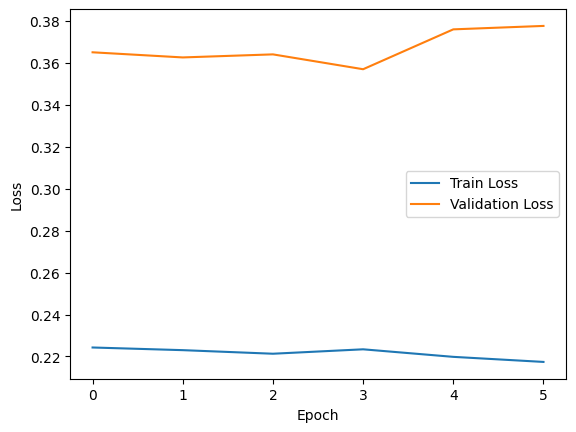

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label="Train Loss")
plt.plot(val_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()